In [1]:
%load_ext autoreload
%autoreload 2

## 1. Imports

In [2]:
import gzip
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split



from norch.nn import MLP
from norch.optim import SGD
from norch.loss import HingeLoss, CrossEntropyWithLogitsLoss

## 2. Data

### 2.1. Load Data

In [53]:
# load and decompress the dictionary from the file using pickle and gzip
with gzip.open('data/mnist.pkl.gz', 'rb') as f:
    loaded_dict = pickle.load(f)

# print the loaded dictionary
X = loaded_dict['X']
y = loaded_dict['y']


Shape of X:  (70000, 784)
Shape of y:  (70000,)
Number of unique labels:  10


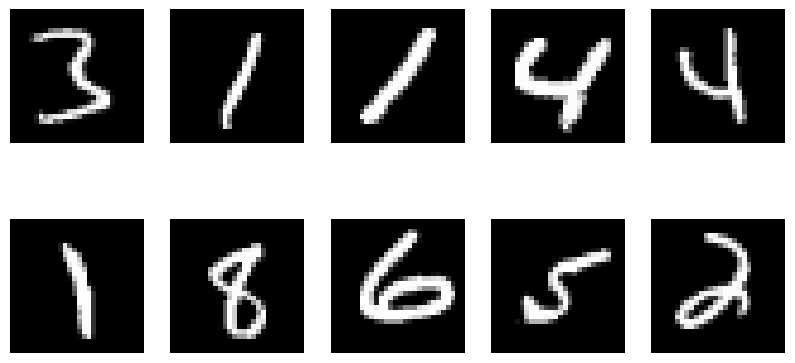

In [4]:
# Data exploration of mnist dataset
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

print("Number of unique labels: ", len(np.unique(y)))

# Plot some examples from the dataset
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(X[np.random.randint(0, len(X))].reshape(28, 28), cmap='gray')
        ax[i, j].axis('off')

From the we see that MNIST dataset has 70,000 image data points. Each image is 28x28 pixels. The labels are the digits 0-9.

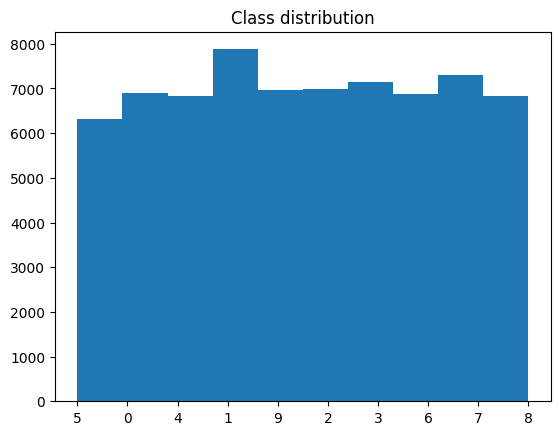

In [5]:
# Visualize class distribution
plt.hist(y, bins=10)
plt.title("Class distribution")
plt.show()

From the above plot we see that the data is balanced. Each digit has approximately 7,000 images.

### 2.3. Data Preprocessing

In [6]:
# Convert to one-hot encoding
y_onehot = np.zeros((len(y), 10))
y_onehot[np.arange(len(y)), y.astype(int)] = 1


# Split data into train, val, and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.3, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train, shuffle=True)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 34300
Validation set size: 14700
Test set size: 21000


In [7]:
# Normalize data
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

### 2.4. Feature Engineering

In [8]:
# Dimensionality reduction using PCA
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

## 3. Modeling 
### 3.1. Model variables

In [9]:
# Set varaibles
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

learning_rate = 0.01
batch_size = 64
epochs = 100

# Patience for early stopping (number of epochs to wait before stopping). This is used to prevent overfitting and stop training when the model stops improving for a certain number of epochs.
patience = 10


## 4. Model with 2 Hidden Layers 
### (Sigmoid Activation and Cross Entropy Loss)

### 4.1. Model Selection
Here, we train a model with 2 hidden layers with `Sigmoid` activation, `CrossEntropyWithLogits` loss and `SGD` optimizer. We find the best learning rate using grid search by training on train set and validating on val set. We reserve test set for final evaluation. We then train the model with the best learning rate on the entire train and val set, and evaluate on test set.

In [10]:
hidden_dims = [128, 64]

In [11]:
# Grid search
best_learning_rate = 0  # initialize the best learning rate to zero
best_val_accuracy = 0  # initialize the best validation accuracy to zero
for learning_rate in [0.5, 0.1, 0.01]:  # loop through different learning rates to find the best one
    # create a MLP model with specified architecture, optimizer with current learning rate, and loss function
    model_2h = MLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, init_method='normal', activation='sigmoid', verbose=False)
    optimizer = SGD(model_2h.param, lr=learning_rate)
    loss_fn = CrossEntropyWithLogitsLoss()
    
    # train the model on the training data, with early stopping and validation set to monitor the model's performance
    train_loss, val_loss = model_2h.fit(X_train=X_train, y_train=y_train, loss_fn=loss_fn, optimizer_fn=optimizer, X_val=X_test, y_val=y_test, batch_size=batch_size, epochs=epochs, patience=patience)
    
    # predict the labels of the training and validation sets and calculate their accuracy
    train_y_pred = model_2h.predict(X_train)
    val_y_pred = model_2h.predict(X_val)
    train_accuracy = accuracy_score(y_train.argmax(axis=1), train_y_pred.argmax(axis=1))*100
    val_accuracy = accuracy_score(y_val.argmax(axis=1), val_y_pred.argmax(axis=1))*100
    
    # update the best validation accuracy and learning rate if the current validation accuracy is higher
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_learning_rate = learning_rate
        
    # print the learning rate, training accuracy, and validation accuracy for the current iteration
    print(f"Learning rate: {learning_rate} Train accuracy: {train_accuracy:.2f}% Val accuracy: {val_accuracy:.2f}%")


Learning rate: 0.5 Train accuracy: 99.28% Val accuracy: 93.24%
Learning rate: 0.1 Train accuracy: 98.55% Val accuracy: 93.07%
Learning rate: 0.01 Train accuracy: 89.67% Val accuracy: 87.69%


### 4.2. Model training for 2 hidden layers with best learning rate

In [12]:
# Print model architecture
print(model_2h)

MLP(
  (0): Linear(in_features=153, out_features=128, init_method="normal")
  (1): Sigmoid()
  (2): Linear(in_features=128, out_features=64, init_method="normal")
  (3): Sigmoid()
  (4): Linear(in_features=64, out_features=10, init_method="normal")
)


In [13]:
# Initialize the MLP model with given input, hidden and output dimensions, using 'normal' initialization and 'sigmoid' activation function
model_2h = MLP(input_dim, hidden_dims, output_dim, init_method='normal', activation='sigmoid', verbose=True)

# Initialize SGD optimizer with best learning rate from model selection
optimizer = SGD(model_2h.param, lr=best_learning_rate)

# Initialize the CrossEntropyWithLogitsLoss
loss_fn = CrossEntropyWithLogitsLoss()

# Concatenate the training and validation data along the first axis
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

# Train the model on the concatenated training and validation data and evaluate on the test data
# Use the CrossEntropyWithLogitsLoss as loss function and SGD optimizer
# Use a batch size of 'batch_size' and train for 'epochs' with early stopping if val loss does not improve for 'patience' epochs
print(f"Training with best learning rate of {best_learning_rate} from model selection...")
train_loss, val_loss = model_2h.fit(X_train=X_train_val, y_train=y_train_val, loss_fn=loss_fn, optimizer_fn=optimizer, X_val=X_test, y_val=y_test, batch_size=batch_size, epochs=epochs, patience=patience)


Training with best learning rate of 0.5 from model selection...
Epoch [1/100] - train_loss: 0.7510 - val_loss: 0.4675
Epoch [2/100] - train_loss: 0.3663 - val_loss: 0.3627
Epoch [3/100] - train_loss: 0.2883 - val_loss: 0.3210
Epoch [4/100] - train_loss: 0.2425 - val_loss: 0.2941
Epoch [5/100] - train_loss: 0.2112 - val_loss: 0.2759
Epoch [6/100] - train_loss: 0.1873 - val_loss: 0.2576
Epoch [7/100] - train_loss: 0.1687 - val_loss: 0.2482
Epoch [8/100] - train_loss: 0.1524 - val_loss: 0.2402
Epoch [9/100] - train_loss: 0.1391 - val_loss: 0.2368
Epoch [10/100] - train_loss: 0.1275 - val_loss: 0.2355
Epoch [11/100] - train_loss: 0.1169 - val_loss: 0.2309
Epoch [12/100] - train_loss: 0.1076 - val_loss: 0.2288
Epoch [13/100] - train_loss: 0.1000 - val_loss: 0.2231
Epoch [14/100] - train_loss: 0.0922 - val_loss: 0.2231
Epoch [15/100] - train_loss: 0.0860 - val_loss: 0.2186
Epoch [16/100] - train_loss: 0.0797 - val_loss: 0.2181
Epoch [17/100] - train_loss: 0.0743 - val_loss: 0.2196
Epoch [18/

### 4.3. Model Evaluation

#### 4.3.1. Loss plot

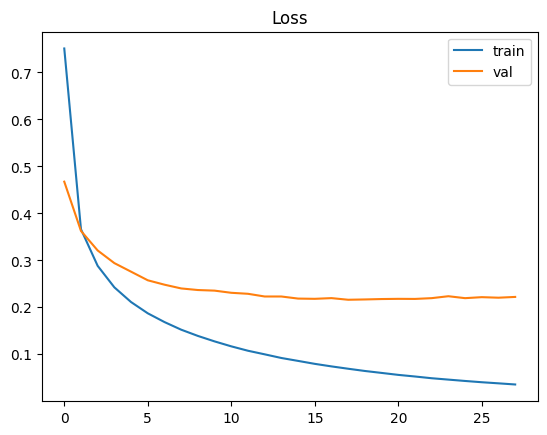

In [14]:
# Plot loss using matplotlib
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.title('Loss')
plt.legend()
plt.show()

#### 4.3.2. Accuracy  and Classification Report

In [30]:
# Predict the classes for the test set
y_pred = model_2h.predict(X_test)

# Calculate the accuracy of the predicted classes compared to true labels in test set
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)).round(4)*100

# Print the accuracy on the test set
print(f"Test accuracy: {accuracy} %")

# Generate classification report which includes precision, recall, f1-score, and support for each class in the test set
report = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), output_dict=True)

# Convert the report to a Pandas DataFrame and set the index name to 'class'
report = pd.DataFrame(report).transpose().round(2)
report['support'] = report['support'].astype(int)
report.index.name = 'class'
report

Test accuracy: 94.21000000000001 %


,precision,recall,f1-score,support
class,,,,
0,0.95,0.98,0.96,2071
1,0.98,0.98,0.98,2363
2,0.95,0.92,0.94,2097
3,0.93,0.92,0.93,2142
4,0.94,0.94,0.94,2047
5,0.93,0.92,0.92,1894
6,0.95,0.96,0.96,2063
7,0.95,0.95,0.95,2188
8,0.91,0.93,0.92,2048


### 4.4. Predictions

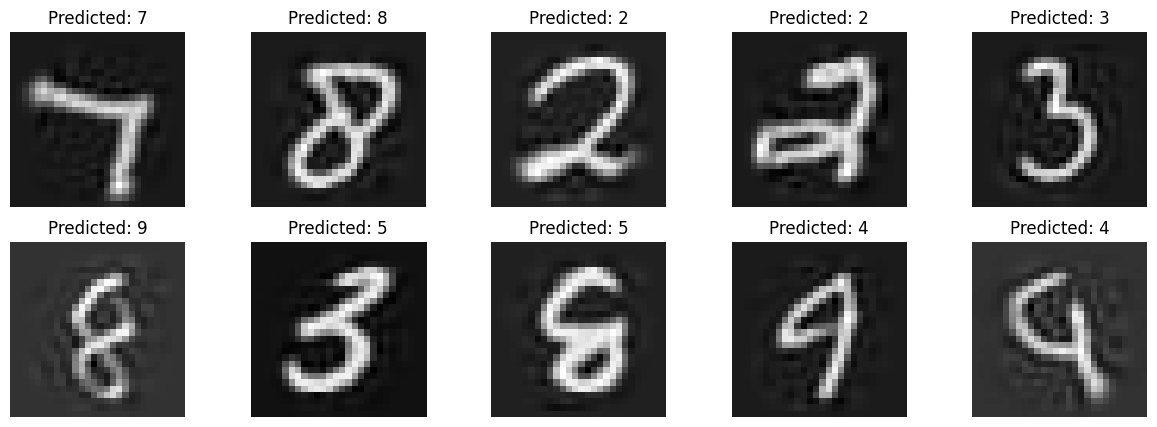

In [16]:
# Plot some of the correctly classified images and misclassified images in a 2x5 grid
# Use the predict method to get the predicted class for each image in the test set
y_pred = model_2h.predict(X_test)

# Get the indices of the correctly classified images
correct_indices = np.where(y_pred.argmax(axis=1) == y_test.argmax(axis=1))[0]

# Get the indices of the misclassified images
incorrect_indices = np.where(y_pred.argmax(axis=1) != y_test.argmax(axis=1))[0]

# Plot the correctly classified images
plt.figure(figsize=(15, 5))
for i, index in enumerate(correct_indices[:5]):
    plt.subplot(2, 5, i+1)
    plt.imshow(pca.inverse_transform(X_test[index]).reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {y_pred[index].argmax()}")
    plt.axis('off')

# Plot the misclassified images
for i, index in enumerate(incorrect_indices[:5]):
    plt.subplot(2, 5, i+6)
    plt.imshow(pca.inverse_transform(X_test[index]).reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {y_pred[index].argmax()}")
    plt.axis('off')

plt.show()

## 5. Three-layer MLP with 3 hidden units
### (ReLU Activation and Hinge Loss)
### 5.1. Model Selection
Here, we train a model with 3 hidden layers with `ReLU` activation, `Hinge` loss and `SGD` optimizer. We find the best learning rate using grid search by training on train set and validating on val set. We reserve test set for final evaluation. We then train the model with the best learning rate on the entire train and val set, and evaluate on test set.

In [19]:
# Three layer MLP with 128, 64 and 32 hidden units
hidden_dims = [128, 64, 32]

# Grid search
best_learning_rate = 0
best_val_accuracy = 0
best_margin = 0

# Iterate over learning rates and train the model for each rate
for learning_rate in [0.01, 0.001]:
    for margin in [1, 2]:
        # Initialize a three-layer MLP with sigmoid activation and normal initialization
        model_h3 = MLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, init_method='normal', activation='relu', verbose=False)
        # Initialize the optimizer with the current learning rate
        optimizer = SGD(model_h3.param, lr=learning_rate)
        # Initialize the loss function
        loss_fn = HingeLoss(margin=margin)
        
        # Train the model using fit method
        train_loss, val_loss = model_h3.fit(X_train=X_train, y_train=y_train, loss_fn=loss_fn, optimizer_fn=optimizer, X_val=X_test, y_val=y_test, batch_size=batch_size, epochs=epochs, patience=patience)
        
        # Get predictions and calculate accuracy
        train_y_pred = model_h3.predict(X_train)
        val_y_pred = model_h3.predict(X_val)
        train_accuracy = accuracy_score(y_train.argmax(axis=1), train_y_pred.argmax(axis=1))*100
        val_accuracy = accuracy_score(y_val.argmax(axis=1), val_y_pred.argmax(axis=1))*100
        
        # Check if the current validation accuracy is better than the best one found so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_learning_rate = learning_rate
            best_margin = margin
        
        # Print the accuracy for the current learning rate
        print(f"Learning rate: {learning_rate} and margin: {margin}: Train accuracy: {train_accuracy:.2f}%, Val accuracy: {val_accuracy:.2f}%")


Learning rate: 0.01 and margin: 1: Train accuracy: 95.27%, Val accuracy: 92.08%
Learning rate: 0.01 and margin: 2: Train accuracy: 96.44%, Val accuracy: 93.01%
Learning rate: 0.001 and margin: 1: Train accuracy: 87.24%, Val accuracy: 86.09%
Learning rate: 0.001 and margin: 2: Train accuracy: 88.25%, Val accuracy: 86.97%


### 5.2. Model training for 3 hidden layers with best learning rate

In [20]:
# Print model architecture
print(model_h3)

MLP(
  (0): Linear(in_features=153, out_features=128, init_method="normal")
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, init_method="normal")
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, init_method="normal")
  (5): ReLU()
  (6): Linear(in_features=32, out_features=10, init_method="normal")
)


In [25]:
# Three layer MLP with 128, 64, and 32 hidden units

# Initialize the MLP model with given input, hidden and output dimensions, using 'normal' initialization and 'sigmoid' activation function
model_h3 = MLP(input_dim, hidden_dims, output_dim, init_method='normal', activation='relu', verbose=True)

# Initialize SGD optimizer with best learning rate from model selection
optimizer = SGD(model_h3.param, lr=best_learning_rate)

# Initialize the Hinge Loss function with best margin from model selection
loss_fn = HingeLoss(margin=best_margin)

# Concatenate the training and validation data along the first axis
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

# Train the model on the concatenated training and validation data and evaluate on the test data
# Use the CrossEntropyWithLogitsLoss as loss function and SGD optimizer
# Use a batch size of 'batch_size' and train for 'epochs' with early stopping if val loss does not improve for 'patience' epochs
print(f"Training with best learning rate of {best_learning_rate} and margin of {best_margin} from model selection ...\n")
train_loss, val_loss = model_h3.fit(X_train=X_train_val, y_train=y_train_val, loss_fn=loss_fn, optimizer_fn=optimizer, X_val=X_test, y_val=y_test, batch_size=batch_size, epochs=epochs, patience=patience)


Training with best learning rate of 0.01 and margin of 2 from model selection ...

Epoch [1/100] - train_loss: 48.3496 - val_loss: 8.5491
Epoch [2/100] - train_loss: 5.9915 - val_loss: 5.8911
Epoch [3/100] - train_loss: 4.0873 - val_loss: 4.2583
Epoch [4/100] - train_loss: 3.3142 - val_loss: 5.0113
Epoch [5/100] - train_loss: 2.7547 - val_loss: 2.8431
Epoch [6/100] - train_loss: 2.4082 - val_loss: 2.6757
Epoch [7/100] - train_loss: 2.1588 - val_loss: 2.9635
Epoch [8/100] - train_loss: 1.9454 - val_loss: 2.2034
Epoch [9/100] - train_loss: 1.7930 - val_loss: 2.7262
Epoch [10/100] - train_loss: 1.6899 - val_loss: 2.2720
Epoch [11/100] - train_loss: 1.5797 - val_loss: 2.3868
Epoch [12/100] - train_loss: 1.5050 - val_loss: 1.8856
Epoch [13/100] - train_loss: 1.4107 - val_loss: 1.9532
Epoch [14/100] - train_loss: 1.3571 - val_loss: 2.2125
Epoch [15/100] - train_loss: 1.3114 - val_loss: 2.3091
Epoch [16/100] - train_loss: 1.2621 - val_loss: 1.9957
Epoch [17/100] - train_loss: 1.1991 - val_los

### 5.3. Model Evaluation

#### 5.3.1. Loss plot

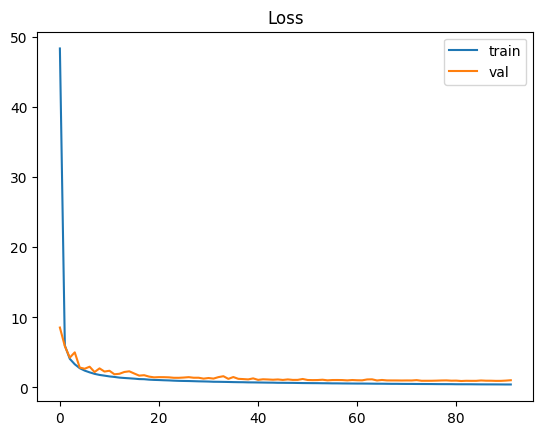

In [26]:
# Plot loss using matplotlib
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.title('Loss')
plt.legend()
plt.show()

#### 5.3.2. Accuracy and Classification Report

In [28]:
# Accuracy on train and test set
y_pred = model_h3.predict(X_test)
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))*100
print(f"Test accuracy: {accuracy} %")


# Classification report
report = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), output_dict=True)
report = pd.DataFrame(report).transpose().round(2)
report['support'] = report['support'].astype(int)
report.index.name = 'class'
report


Test accuracy: 93.32857142857142 %


,precision,recall,f1-score,support
class,,,,
0,0.97,0.97,0.97,2071
1,0.97,0.98,0.97,2363
2,0.98,0.87,0.92,2097
3,0.83,0.96,0.89,2142
4,0.95,0.92,0.94,2047
5,0.93,0.90,0.92,1894
6,0.94,0.98,0.96,2063
7,0.94,0.94,0.94,2188
8,0.91,0.90,0.90,2048


### 5.4. Predictions

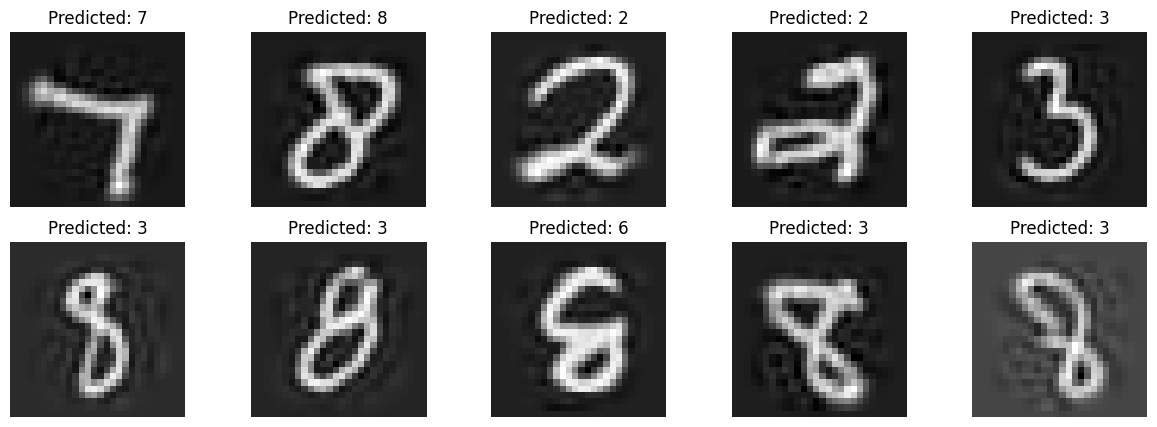

In [29]:
# Plot some of the correctly classified images and misclassified images in a 2x5 grid
# Use the predict method to get the predicted class for each image in the test set
y_pred = model_h3.predict(X_test)

# Get the indices of the correctly classified images
correct_indices = np.where(y_pred.argmax(axis=1) == y_test.argmax(axis=1))[0]

# Get the indices of the misclassified images
incorrect_indices = np.where(y_pred.argmax(axis=1) != y_test.argmax(axis=1))[0]

# Plot the correctly classified images
plt.figure(figsize=(15, 5))
for i, index in enumerate(correct_indices[:5]):
    plt.subplot(2, 5, i+1)
    plt.imshow(pca.inverse_transform(X_test[index]).reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {y_pred[index].argmax()}")
    plt.axis('off')

# Plot the misclassified images
for i, index in enumerate(incorrect_indices[:5]):
    plt.subplot(2, 5, i+6)
    plt.imshow(pca.inverse_transform(X_test[index]).reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {y_pred[index].argmax()}")
    plt.axis('off')

plt.show()

## Conclusion
- We have successfully implemented a three layer MLP from scratch and trained it on the MNIST dataset.
- We used PCA to reduce the dimensionality of the data and then trained the model on the reduced data.
- We used grid search to find the best learning rate for the model.
- We used early stopping to prevent overfitting.
- We used the CrossEntropyWithLogitsLoss and HingeLoss functions along with the SGD optimizer.
- We achieved an accuracy more than 90% on the test set.

## References
- https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/


In [41]:
# Read train-images-idx3-ubyte.gz and train-labels-idx1-ubyte.gz
import gzip

def read_mnist(images_path, labels_path):
    with gzip.open(labels_path, 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        X_train = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(y_train), 784)
    return X_train, y_train

X_train, y_train = read_mnist('../../../../../Downloads/train-images-idx3-ubyte', '../../../../../Downloads/train-labels-idx1-ubyte')

FileNotFoundError: [Errno 2] No such file or directory: '../../../../../Downloads/train-labels-idx1-ubyte'

In [39]:
ls ../../../../../Downloads/

325f3a530ad9bb6fc2e4a193c6ef6de5-1673029923.pdf
4532-Article Text-7571-1-10-20190706.pdf
Affidavit_of_Age_and_Identity.pdf
Apocalust_0.05_Mac.zip
Archive/
Archive.zip
BlueStacksInstaller_4.270.1.2803_d6635d1354ffde0333a03d510a97467b.dmg
BreakTimer.dmg
C-HMCNN/
Education_.docx
GuiltyPleasure.app/
Homework2.pdf
Homework3.pdf
IMG_3868.HEIC
Lecture 17, 18, 19 & 20_ Dynamic Programming .pdf
Lecture 3 v3.pdf
Lecture 5.pdf
Loom-0.156.5-arm64.dmg
M-T5534GCPA-1005.3[E230].zip
Midterm-I.pdf
NSSTC-UAH-WIRELESS-prakashs-work-macbook-pro.p12
Post-midterm brushup.pdf
Q8.jpg
Resume-Prakash-Chaudhary.pdf
archive-2/
cover_letter.pdf
data/
draw.io-arm64-20.8.16.dmg
events-export.zip
googlechrome.dmg
gs_masters_pos.pdf
hiercost/
hw1_prakash_chaudhary.pdf
hw1_ucs_graph.png
image.png
mac_macos.pdf
ms-toolsai.jupyter-2023.2.1000401035.vsix
naturalcomputing-chapter3.pdf
personal_statement.pdf
renpy-8.0.3-sdk.dmg
resume.pdf
sciencekeywords.csv
the-witcher-enhanced-edition-356792.torrent
train-images.idx3-ubyt